In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.io import ascii
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
from scipy import interpolate
from scipy import integrate
from filters import Filters


In [2]:
c = const.c.to('cm/s').value

In [3]:
def Lbol(x,y):
    x = np.log10(x[~np.isnan(y)])
    y = np.log10(y[~np.isnan(y)])

    Lbol_interp = interpolate.interp1d(x[y>0],y[y>0],kind='linear',fill_value='extrapolate')

    x_interp = np.linspace(min(x),max(x),1000)
    y_interp = 10**Lbol_interp(x_interp)

    plt.plot(10**x_interp*1E4,y_interp)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    x_interp, y_interp = x_interp[::-1], y_interp[::-1]

    freq = c/10**x_interp
    y_interp = y_interp/freq

    Lbol = integrate.trapz(y_interp,freq)

    return Lbol 


def PlotSED(x, y, x_opt=[np.nan], y_opt=[np.nan], x_opt2=[np.nan], y_opt2=[np.nan]):
    plt.plot(x,y,c='b',lw=2.5)
    plt.plot(x_opt,y_opt,c='orange',lw=1.5)
    plt.plot(x_opt2,y_opt2,c='black',lw=1.0)
    plt.xlabel(r'Rest Wavelength [$\mu$m]', fontsize=22)
    plt.ylabel(r'$\lambda$L$_\lambda$', fontsize=22)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1E41, 1E44)
    # plt.xlim(5E-5, 7E2)
    plt.grid()
    plt.show()

def Flux_to_Lum(F, z):
    '''Function to convert flux to luminosity'''
    cosmo = FlatLambdaCDM(H0=70, Om0=0.29, Tcmb0=2.725)

    dl = cosmo.luminosity_distance(z).value  # Distance in Mpc
    dl_cgs = dl*(3.0856E24)  # Distance from Mpc to cm

    # convert flux to luminosity
    L = F*4*np.pi*dl_cgs**2

    return L

def MakeSED(z,filter_name,flux,flux_err):
    obs_w = Filters('filter_list.dat').pull_filter(filter_name,'central wavelength')
    rest_w = obs_w/(1+z)
    obs_w_cgs = rest_w*1E-8
    rest_w_microns = rest_w*1E-4
    rest_w_cgs = rest_w*1E-8
    rest_freq = c/rest_w_cgs
    obs_freq = c/obs_w_cgs

    flux_jy = flux*1E-6
    flux_err_jy = flux_err*1E-6

    flux_jy[flux_jy < 0] = np.nan
    flux_jy[flux_err_jy < 0] = np.nan
    flux_err_jy[flux_err_jy < 0] = np.nan

    Fnu = flux_jy*1E-23
    Fnu_err = flux_jy*1E-23
    Flambda = Fnu*(c/obs_w_cgs**2)
    Flambda_err = Fnu_err*(c/obs_w_cgs**2)

    lambdaF_lambda = Flambda*obs_w_cgs
    lambdaF_lambda_err = Flambda_err*obs_w_cgs
    lambdaL_lambda = Flux_to_Lum(lambdaF_lambda,z)
    lambdaL_lambda_err = Flux_to_Lum(lambdaF_lambda_err,z)

    nuF_nu = obs_freq*Fnu
    nuF_nu_err = obs_freq*Fnu_err
    nuL_nu = Flux_to_Lum(nuF_nu, z)
    nuL_nu_err = Flux_to_Lum(nuF_nu_err, z)

    x = np.log10(rest_w_microns[~np.isnan(nuL_nu)])
    y = np.log10(nuL_nu[~np.isnan(nuL_nu)])

    L_interp = interpolate.interp1d(x[10**y>0],y[10**y>0],kind='linear',fill_value='extrapolate')
    Lone = L_interp(np.log10(1.0))

    x_out = np.log10(np.linspace(min(10**x[10**y > 0]), max(10**x[10**y > 0]), 5000))
    y_out = L_interp(x_out)

    return 10**x_out, 10**y_out, 10**Lone

def Temp_sub(z,Lnorm,x,y,tx,ty,scale_L):
    try:
        Lone_temp = ty[tx == 1.0050][0]
    except IndexError:
        Lone_temp = ty[np.round(tx, 5) == 1.0][0]

    if z <= 0.6:
        if Lnorm < scale_L[0]:
            scale = Lnorm/Lone_temp
        else:
            scale = scale_L[0]/Lone_temp
    elif (z > 0.6) & (z < 0.9):
        if Lnorm < scale_L[1]:
            scale = Lnorm/Lone_temp
        else:
            scale = scale_L[1]/Lone_temp
    else:
        if Lnorm < scale_L[2]:
            scale = Lnorm/Lone_temp
        else:
            scale = scale_L[2]/Lone_temp 

    # scale = 1

    ty_scale = ty*scale
    
    temp_interp = interpolate.interp1d(np.log10(tx),np.log10(ty_scale),kind='linear',fill_value='extrapolate')
    x_temp_interp = np.log10(np.linspace(min(x), max(x), 5000))
    y_temp_interp = temp_interp(x_temp_interp)

    y_out = y - 10**y_temp_interp

    return 10**x_temp_interp, 10**y_temp_interp, y_out    





In [4]:
COSMOS_filters = np.array(['Fx_hard', 'Fx_soft', 'FLUX_GALEX_FUV', 'FLUX_GALEX_NUV', 'U', 'G', 'R', 'I', 'Z', 'yHSC_FLUX_APER2', 'JVHS', 'H_FLUX_APER2',
                          'Ks_FLUX_APER2', 'SPLASH_1_FLUX', 'SPLASH_2_FLUX', 'SPLASH_3_FLUX', 'SPLASH_4_FLUX', 'FLUX_24', 'FLUX_100', 'FLUX_160', 'FLUX_250', 'FLUX_350', 'FLUX_500'])
ind=20

In [5]:
with fits.open('/Users/connor_auge/Research/Disertation/AGN_SEDs/AHA_SED_paper1/Final_plots/a_six/a_final/SED_paper_tables/Appendix_Table3_2.fits') as hdul:
    cols = hdul[1].columns
    data = hdul[1].data 

with fits.open('/Users/connor_auge/Research/Disertation/AGN_SEDs/AHA_SED_paper1/Final_plots/a_six/a_final/SED_paper_tables/Appendix_Table1.fits') as hdul:
    cols2 = hdul[1].columns
    data2 = hdul[1].data

field = data2['field']
id2 = data2['phot_id']
z = data2['z_spec']
lbol = data2['Lbol']

id2 = id2[field == 'COSMOS']
z = z[field == 'COSMOS']
lbol = lbol[field == 'COSMOS']

ellip = ascii.read('/Users/connor_auge/Research/templets/A10_templates.txt')
ellip_wave = np.asarray(ellip['Wave'])
ellip_flux = np.asarray(ellip['E'])*1E-16
ellip_wave_cgs = ellip_wave*1E-8
ellip_freq = c/ellip_wave_cgs
ellip_nuFnu = ellip_flux*ellip_freq

dl = 10
dl_cgs = dl*3.086E18
ellip_lum = ellip_nuFnu*4*np.pi*dl_cgs**2

sf = ascii.read('/Users/connor_auge/Research/templets/M82.csv')
sf_wave = np.asarray(sf['wave'])
sf_lum = np.asarray(sf['lum'])


In [6]:
id = data['phot_id'][ind]
z2 = z[id2 == id]
lbol_obj = lbol[id2 == id]
print(id)

flux_array = np.array([
    data['Fxh'][ind],
    data['Fxs'][ind], 
    data['FUV'][ind],
    data['NUV'][ind],
    data['u'][ind], 
    data['g'][ind],
    data['r'][ind], 
    data['i'][ind], 
    data['z'][ind], 
    data['y'][ind], 
    data['J'][ind],
    data['H'][ind], 
    data['Ks'][ind], 
    data['IRAC1'][ind], 
    data['IRAC2'][ind], 
    data['IRAC3'][ind], 
    data['IRAC4'][ind], 
    data['F24'][ind], 
    data['F100'][ind],
    data['F160'][ind],
    data['F250'][ind], 
    data['F350'][ind], 
    data['F500'][ind]])

flux_err_array = np.array([
    data['Fxh_err'][ind],
    data['Fxs_err'][ind],
    data['FUV_err'][ind],
    data['NUV_err'][ind],
    data['u_err'][ind],
    data['g_err'][ind],
    data['r_err'][ind],
    data['i_err'][ind],
    data['z_err'][ind],
    data['y_err'][ind],
    data['J_err'][ind],
    data['H_err'][ind],
    data['Ks_err'][ind],
    data['IRAC1_err'][ind],
    data['IRAC2_err'][ind],
    data['IRAC3_err'][ind],
    data['IRAC4'][ind],
    data['F24_err'][ind],
    data['F100_err'][ind],
    data['F160_err'][ind],
    data['F250_err'][ind],
    data['F350_err'][ind],
    data['F500_err'][ind]])


scale_array = [1.12E44, 1.72E44, 2.27E44]


205032


In [7]:
print(id)
print(lbol_obj)

205032
[44.127]


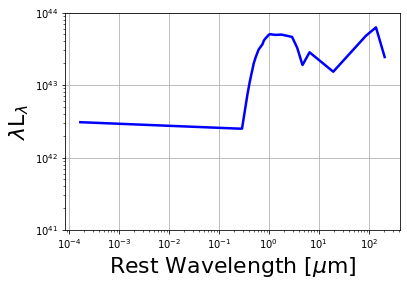

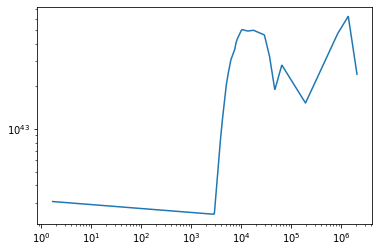

2.3281303570552574e+44 44.367007293746234


In [8]:
x, y, Lnorm = MakeSED(z2,COSMOS_filters,flux_array,flux_err_array)
PlotSED(x,y)
lbol_full = Lbol(x,y)
print(lbol_full,np.log10(lbol_full))

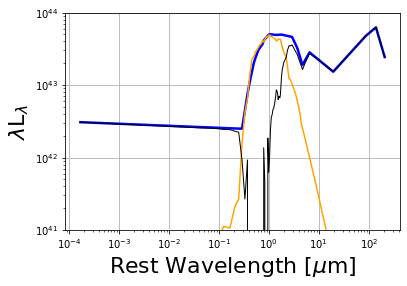

/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_26317/72434737.py:3: RuntimeWarning: invalid value encountered in log10
  y = np.log10(y[~np.isnan(y)])


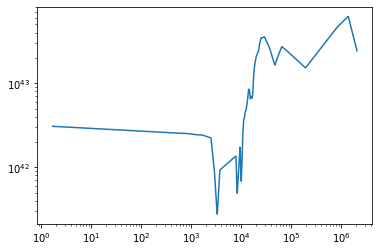

1.644531909743144e+44 44.216042304751426


In [9]:
x_sub, y_temp, y_sub = Temp_sub(z2,Lnorm,x,y,ellip_wave,ellip_lum,scale_array)
PlotSED(x,y,x_sub,y_temp,x_sub,y_sub)
lbol_sub = Lbol(x_sub,y_sub)
print(lbol_sub, np.log10(lbol_sub))

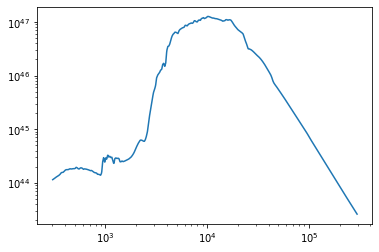

1.831665359450075e+47 47.262846132094175


In [10]:
temp_lbol = Lbol(ellip_wave,ellip_lum)
print(temp_lbol,np.log10(temp_lbol))

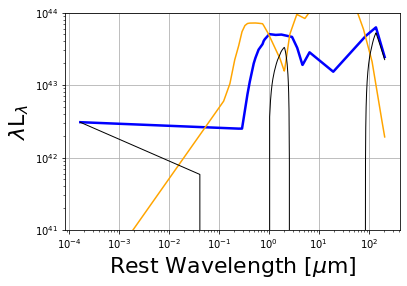

/var/folders/_6/vw02nk9n7g11l58s8rrjb9k80000gn/T/ipykernel_26317/72434737.py:3: RuntimeWarning: invalid value encountered in log10
  y = np.log10(y[~np.isnan(y)])


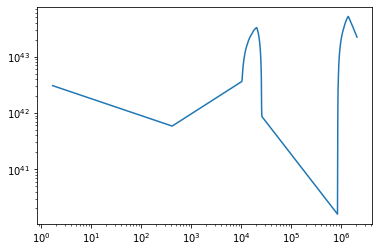

6.084069030790372e+43 43.78419413298143


In [11]:
x_sub, y_temp, y_sub = Temp_sub(z2,Lnorm,x,y,sf_wave,sf_lum,scale_array)
PlotSED(x,y,x_sub,y_temp,x_sub,y_sub)
lbol_sub = Lbol(x_sub,y_sub)
print(lbol_sub, np.log10(lbol_sub))

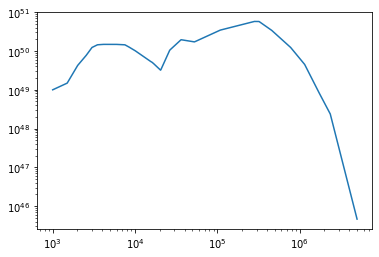

1.3820241822398042e+51 51.14051564225773


In [12]:
temp_lbol = Lbol(sf_wave,sf_lum)
print(temp_lbol,np.log10(temp_lbol))